In [ ]:
!pip install ray torch torchvision pymysql


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import torch

# Check GPU availability
if not torch.cuda.is_available():
    raise EnvironmentError("No GPU found! Please enable GPU in Google Colab.")

device = torch.device("cuda")
print("Using GPU:", torch.cuda.get_device_name(0))


Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import ray
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
import pymysql
import logging
import time
import numpy as np


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ray.shutdown()  # Reset Ray to avoid conflicts
ray.init(num_gpus=1, object_store_memory=4 * 1024 * 1024 * 1024)  # 4 GB for the object store
logging.info("Ray initialized with increased object store memory.")


2024-12-09 00:18:03,014	INFO worker.py:1821 -- Started a local Ray instance.


In [ ]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode
model = model.to(device)  # Move to GPU

# Save the model state dictionary to Ray object store
model_state_dict_ref = ray.put(model.state_dict())
logging.info("Model state dictionary saved to Ray object store.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset (CIFAR-10 as a placeholder for ImageNet)
dataset = datasets.CIFAR10(root="./data", download=True, transform=transform)

# Halve the dataset
half_dataset = Subset(dataset, range(len(dataset) // 2))
logging.info(f"Dataset halved: {len(half_dataset)} samples.")

# Create DataLoader with an adjusted batch size
data_loader = DataLoader(half_dataset, batch_size=20, shuffle=False)  # Batch size adjusted to 20
logging.info("DataLoader created with batch size of 20.")


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
@ray.remote(num_gpus=0.5)  # Fractional GPU allocation
class BatchProcessor:
    def __init__(self, model_state_dict):
        from torchvision import models
        import torch
        self.device = torch.device("cuda")
        self.model = models.resnet50()
        self.model.load_state_dict(model_state_dict)
        self.model = self.model.to(self.device)

    def process(self, batch, task_id):
        import numpy as np
        batch = batch.to(self.device)
        with torch.no_grad():
            predictions = self.model(batch).cpu().numpy()

        # Save predictions to a local file
        file_name = f"predictions_{task_id}.npy"
        np.save(file_name, predictions)
        return file_name


In [ ]:
# Create a pool of actors
num_actors = 2  # Limit the number of parallel workers
actors = [BatchProcessor.remote(model_state_dict_ref) for _ in range(num_actors)]
from ray.util import ActorPool
pool = ActorPool(actors)


In [ ]:
logging.info("Submitting batches to the ActorPool...")
all_prediction_files = []

# Submit tasks to the pool
task_id = 0
for images, _ in data_loader:
    task_id += 1
    pool.submit(lambda a, v: a.process.remote(v, task_id), images)

# Retrieve file paths for predictions
while pool.has_next():
    file_name = pool.get_next()
    all_prediction_files.append(file_name)
    logging.info(f"Retrieved predictions saved in file: {file_name}")

logging.info("All batches processed successfully.")


In [ ]:
# Load all predictions from saved files
all_predictions = []
for file_name in all_prediction_files:
    predictions = np.load(file_name)
    all_predictions.append(predictions)

# Concatenate predictions into a single array
all_predictions_array = np.concatenate(all_predictions, axis=0)
logging.info(f"Total predictions shape: {all_predictions_array.shape}")  # [500, 1000] for 500 images and 1000 classes


In [ ]:
# Define a simple class-to-tag mapping
class_to_tag = {
    0: "Airplane",
    1: "Car",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}


tags = []
for prediction in all_predictions_array:
    class_idx = np.argmax(prediction)
    tags.append(class_to_tag.get(class_idx, "Unknown"))

logging.info(f"Example tags: {tags[:10]}")



In [ ]:
import sqlite3

# Open connection to SQLite database
connection = sqlite3.connect("image_tags.db")
cursor = connection.cursor()

# Clear the table to prevent duplicates
cursor.execute("DELETE FROM Tags")

# Insert tags into SQLite database
for idx, tag in enumerate(tags):
    cursor.execute("INSERT INTO Tags (image_id, tag, confidence_score) VALUES (?, ?, ?)",
                   (idx, tag, 1.0))  # Replace 1.0 with the confidence score if needed

# Commit the changes and close the connection
connection.commit()
connection.close()

print("Tags successfully stored in the SQLite database!")


Tags successfully stored in the SQLite database!


In [ ]:
import sqlite3

# Reconnect to the database
connection = sqlite3.connect("image_tags.db")
cursor = connection.cursor()

# Query the database to verify the stored data
cursor.execute("SELECT * FROM Tags LIMIT 10;")  # Fetch the first 10 rows
rows = cursor.fetchall()

# Print the retrieved rows
for row in rows:
    print(row)

connection.close()


(0, 'Unknown', 1.0)
(1, 'Unknown', 1.0)
(2, 'Unknown', 1.0)
(3, 'Unknown', 1.0)
(4, 'Unknown', 1.0)
(5, 'Unknown', 1.0)
(6, 'Unknown', 1.0)
(7, 'Unknown', 1.0)
(8, 'Unknown', 1.0)
(9, 'Unknown', 1.0)


In [ ]:
# Debug the first few predictions and their class indices
for i, prediction in enumerate(all_predictions_array[:10]):
    class_idx = np.argmax(prediction)
    print(f"Prediction {i}: {prediction[:10]}... (truncated), Class Index: {class_idx}")


Prediction 0: [ 0.56856203  0.11508889 -1.4357857  -2.2441144  -0.22836016 -1.4972486
 -1.3011978   0.89995563  1.4958484  -2.2698472 ]... (truncated), Class Index: 169
Prediction 1: [ 0.3401491  -1.5841061  -1.7211758  -2.146575   -0.9557073   0.02070592
 -1.0444365  -0.7582795   0.00272341 -0.53104985]... (truncated), Class Index: 676
Prediction 2: [-0.6301948   0.23993373  0.05174658 -0.24854651 -0.06158729 -0.43382686
 -2.0935056  -0.882824   -2.27345    -1.0490443 ]... (truncated), Class Index: 784
Prediction 3: [ 1.6439352   0.37884608 -0.8673637   0.07732531  1.1918502   2.2449095
  2.2213898   1.5727905   1.6777456   0.46508342]... (truncated), Class Index: 348
Prediction 4: [-2.858267   -2.0656984   0.62450135 -0.655198   -1.6116347  -2.0858972
 -2.4895432  -2.3573768  -3.223149   -0.931263  ]... (truncated), Class Index: 447
Prediction 5: [-2.5289268   1.9182814  -1.6387143  -3.4016275  -3.3612633  -0.7154172
 -3.1771872   0.42778072 -0.6433515  -1.3163583 ]... (truncated), C

In [ ]:
from torch import nn

# Modify the ResNet model for CIFAR-10
model.fc = nn.Linear(model.fc.in_features, 10)  # Output 10 classes
model.to(device)
logging.info("Modified ResNet50 for CIFAR-10.")


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fine-tune the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}")

logging.info("Model fine-tuning complete.")


Epoch 1/5, Loss: 1.3808056897163392
Epoch 2/5, Loss: 0.9276361530542374
Epoch 3/5, Loss: 0.7101641859412193
Epoch 4/5, Loss: 0.5498482539653778
Epoch 5/5, Loss: 0.41549791491031646


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 82.48%


In [ ]:
tags = []
for prediction in all_predictions_array:
    class_idx = np.argmax(prediction)
    tags.append(class_to_tag.get(class_idx, "Unknown"))

logging.info(f"Example tags: {tags[:10]}")


In [ ]:
import sqlite3

# Connect to the database
connection = sqlite3.connect("image_tags.db")
cursor = connection.cursor()

# Query the first 10 rows
cursor.execute("SELECT * FROM Tags LIMIT 10;")
rows = cursor.fetchall()

# Print the results
for row in rows:
    print(row)

connection.close()


(0, 'Unknown', 1.0)
(1, 'Unknown', 1.0)
(2, 'Unknown', 1.0)
(3, 'Unknown', 1.0)
(4, 'Unknown', 1.0)
(5, 'Unknown', 1.0)
(6, 'Unknown', 1.0)
(7, 'Unknown', 1.0)
(8, 'Unknown', 1.0)
(9, 'Unknown', 1.0)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Perform batch inference with the fine-tuned model
model.eval()
tags = []
with torch.no_grad():
    for batch in data_loader:
        inputs, _ = batch
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        for pred in predictions:
            tag = class_to_tag.get(pred, "Unknown")
            tags.append(tag)


In [ ]:
connection = sqlite3.connect("image_tags.db")
cursor = connection.cursor()

# Clear the table to prevent duplicates
cursor.execute("DELETE FROM Tags")

# Insert updated tags
for idx, tag in enumerate(tags):
    cursor.execute("INSERT INTO Tags (image_id, tag, confidence_score) VALUES (?, ?, ?)",
                   (idx, tag, 1.0))

connection.commit()
connection.close()


In [ ]:
# Query the database to check the stored tags
connection = sqlite3.connect("image_tags.db")
cursor = connection.cursor()

cursor.execute("SELECT * FROM Tags LIMIT 10;")
rows = cursor.fetchall()
for row in rows:
    print(row)

connection.close()


(0, 'Frog', 1.0)
(1, 'Truck', 1.0)
(2, 'Truck', 1.0)
(3, 'Deer', 1.0)
(4, 'Car', 1.0)
(5, 'Truck', 1.0)
(6, 'Bird', 1.0)
(7, 'Horse', 1.0)
(8, 'Ship', 1.0)
(9, 'Cat', 1.0)


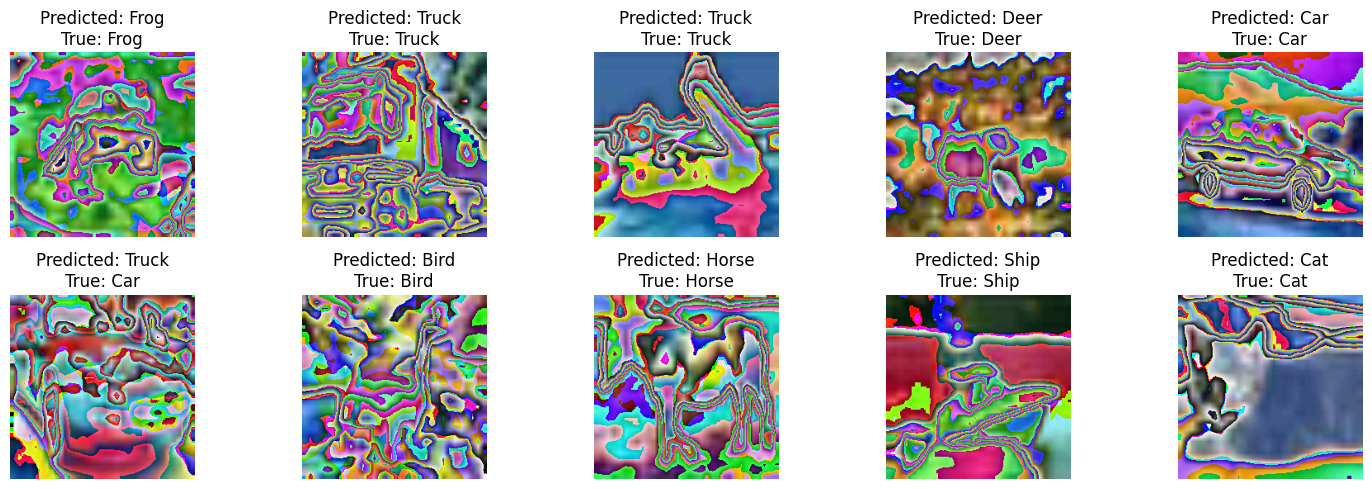

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Create a mapping for ground truth labels if not already defined
class_to_tag = {
    0: "Airplane",
    1: "Car",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

# Initialize an iterator for the data loader
data_iter = iter(data_loader)

# Fetch the first batch of images and labels
images, labels = next(data_iter)
images = images[:10]  # Take only the first 10
labels = labels[:10]

# Perform inference on the batch
model.eval()
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert images to PIL format for visualization
images = images.cpu()
to_pil = ToPILImage()

# Plot the first 10 images with their predictions and true labels
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(to_pil(images[i]))
    plt.title(f"Predicted: {class_to_tag[predicted[i].item()]}\nTrue: {class_to_tag[labels[i].item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
